# Part 2 - Pre-processing
Pre-processing is an important step in data analysis for several reasons.
<br>
1. The data presented to us in the dataset is not easily understandable by the computer. For example, categorical data is presented as (string) objects, which have no meaning to the computer. Also, the computer has no way of identifying attributes like Id and the label from the data.
2. The computer cannot deal with incomplete data, that is, with null values in the dataset. Pre-processing is needed to fill in these nulls or remove that point entirely.
3. Some of the attributes might be skewed or noisy, which will affect the performance and run time of the algorithms. Thus, pre-processing can transform the data to improve the learning performance.

<br>
In this section, we will explore the various types of pre-processing that can be done on the data. These techniques may then be used in the subsequent notebooks when testing the different algorithms.

**Github Link**: https://github.com/leakin185/CE9010Project

__Overview__ <a class="anchor" id="top"></a>
1. [Import](#import)
2. [Dealing With Null Data](#null)
3. [Dealing With Highly Skewed Categorical Data](#cat)
4. [One Hot Encoding](#ohe)
5. [Dealing With Highly Skewed Continuous Data](#cont)
6. [Normalisation](#norm)
7. [Standardization](#stan)
8. [Feature Selection](#feature)

## 1. Import <a class="anchor" id="import"></a>

In [1]:
# Basic Libraries
import math
import numpy as np
import pandas as pd
import seaborn as sb
import researchpy as rp
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from scipy import stats
from scipy.stats import skew 
from sklearn.model_selection import train_test_split
# machine learning library
from sklearn.linear_model import LinearRegression
from sklearn import svm
# data normalization from sklearn
from sklearn.preprocessing import MinMaxScaler
# data standardization from sklearn
from sklearn.preprocessing import StandardScaler
# computational time
import time

In [2]:
#importing the csv dataset
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


[back to top](#top)

## 2. Dealing with null data<a class="anchor" id="null"></a>

This step is always necessary.
<br><br>
From EDA, we learn that the following have attributes have null data:

- LotFrontage : 259
- MasVnrArea  : 8
- Electrical  : 1
- GarageYrBlt : 81

For feature with too many missing values (10% of all data points), remove this feature entirely. 
For feature with only a few missing values, remove those data points.

In [3]:
nullData = [['LotFrontage', 259], ['MasVnrArea', 8], ['Electrical', 1], ['GarageYrBlt', 81]]
n = len(train)
treshold = 0.1
drop = []

print('Drop feature - too many nulls:')
for i in nullData:
    if i[1]/n > treshold: # Arbitrary treshold: 10%
        print(i[0])
        train.drop(columns=[i[0]], inplace=True)
    else:
        drop.append(i[0])
        
print('Remove data point:')
print(drop)
train.dropna(subset=drop, inplace=True)

train.head()

Drop feature - too many nulls:
LotFrontage
Remove data point:
['MasVnrArea', 'Electrical', 'GarageYrBlt']


,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print('Number of columns:', len(train.columns))
print('Number of data:', len(train))

Number of columns: 80
Number of data: 1370


[back to top](#top)

## 3. Dealing With Highly Skewed Categorical Data <a class="anchor" id="cat"></a>

As identifited from data exploration, we removed categorical variables with one category of data occuping >= 90% of data. __This step must be done before one hot encoding.__

In [5]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
#skewness of categorical variables
max_percent = []
catogorical_skewed=[]
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
        max_percent.append(rp.summary_cat(train[i])["Percent"].max())
print ("The number of variables with one category of data which occupies >= 90% of data =", len(max_percent))
#highly skewed categorical variables
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90:
        catogorical_skewed.append(i)
        print (i,"/ratio of the dominant category = ", rp.summary_cat(train[i])["Percent"].max()/100)

The number of variables with one category of data which occupies >= 90% of data = 15
Street /ratio of the dominant category =  0.9964
LandContour /ratio of the dominant category =  0.9015000000000001
Utilities /ratio of the dominant category =  0.9993000000000001
LandSlope /ratio of the dominant category =  0.9467
Condition2 /ratio of the dominant category =  0.9898
RoofMatl /ratio of the dominant category =  0.9818000000000001
BsmtCond /ratio of the dominant category =  0.9246
Heating /ratio of the dominant category =  0.981
CentralAir /ratio of the dominant category =  0.9495999999999999
Electrical /ratio of the dominant category =  0.9226000000000001
Functional /ratio of the dominant category =  0.9336
GarageQual /ratio of the dominant category =  0.9504
GarageCond /ratio of the dominant category =  0.9612999999999999
PavedDrive /ratio of the dominant category =  0.9372
MiscFeature /ratio of the dominant category =  0.9216


In [6]:
for i in catogorical_skewed:
    train.drop(columns=[i], inplace=True)

In [7]:
for i in catogorical_skewed:
    categorical.remove(i)
#skewness of categorical variables
max_percent = []
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
        max_percent.append(rp.summary_cat(train[i])["Percent"].max())
print ("The number of variables with one category of data which occupies >= 90% of data =", len(max_percent))
#highly skewed categorical variables
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
         print (i,"/ratio of the dominant category = ", rp.summary_cat(train[i])["Percent"].max()/100)

The number of variables with one category of data which occupies >= 90% of data = 0


[back to top](#top)

## 4. One Hot Encoding <a class="anchor" id="ohe"></a>
This step is always necessary.
<br><br>
One Hot Encoding is one way of converting categorical data to numerical data. A new binary variable is added for each unique category.

In [8]:
train = pd.get_dummies(train, columns= categorical, prefix= categorical)
train.head()

,Id,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,2,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,3,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,4,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,5,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


[back to top](#top)

## 5. Dealing With Highly Skewed Continuous Data <a class="anchor" id="cont"></a>
For continuous variables with a skewness value of more than 1, we will use the interquartile range (IQR) method to remove the outliers.

In [9]:
# identifying continuous variables with high skewness
continuous = ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
array1 = skew(train[continuous])
#the top 15 features which are the most skewed
index1 = array1.argsort()[-15:][::-1]
continuous_skewed=[]
for i in index1:
    print (continuous[i],": skewness = ", array1[i])
    if array1[i]>=1:
        continuous_skewed.append(continuous[i])

MiscVal : skewness =  24.732979451706033
PoolArea : skewness =  14.342881566937836
LotArea : skewness =  12.025446327344339
LowQualFinSF : skewness =  10.66505349858299
3SsnPorch : skewness =  9.96262046395852
KitchenAbvGr : skewness =  5.129053439295553
BsmtFinSF2 : skewness =  4.174330005566947
ScreenPorch : skewness =  3.967379533802487
BsmtHalfBath : skewness =  3.89811918894981
EnclosedPorch : skewness =  3.214887613130617
MasVnrArea : skewness =  2.588332838278803
OpenPorchSF : skewness =  2.2638025759950504
BsmtFinSF1 : skewness =  1.6941364533315026
TotalBsmtSF : skewness =  1.6330286577439608
WoodDeckSF : skewness =  1.5027101898713007


In [10]:
print('train shape\t:',train.shape)
# calculate interquartile range
q25, q75 = train[continuous_skewed].quantile(0.25), train[continuous_skewed].quantile(0.75)
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

train_iqr = train[~((train>upper)).any(axis=1)]
print('train_iqr shape\t:', train_iqr.shape)

train shape	: (1370, 248)
train_iqr shape	: (688, 248)


In [11]:
#calculating skewness of continuous variables
array = skew(train_iqr[continuous])
#the top 3 features which are the most skewed
print('Top 3 features which are the most skewed:')
index = array.argsort()[-3:][::-1]
for i in index: 
    print (continuous[i],": skewness = ", array[i])

Top 3 features which are the most skewed:
MasVnrArea : skewness =  1.1633497486834365
OpenPorchSF : skewness =  1.0088075868431694
WoodDeckSF : skewness =  0.77571907189836


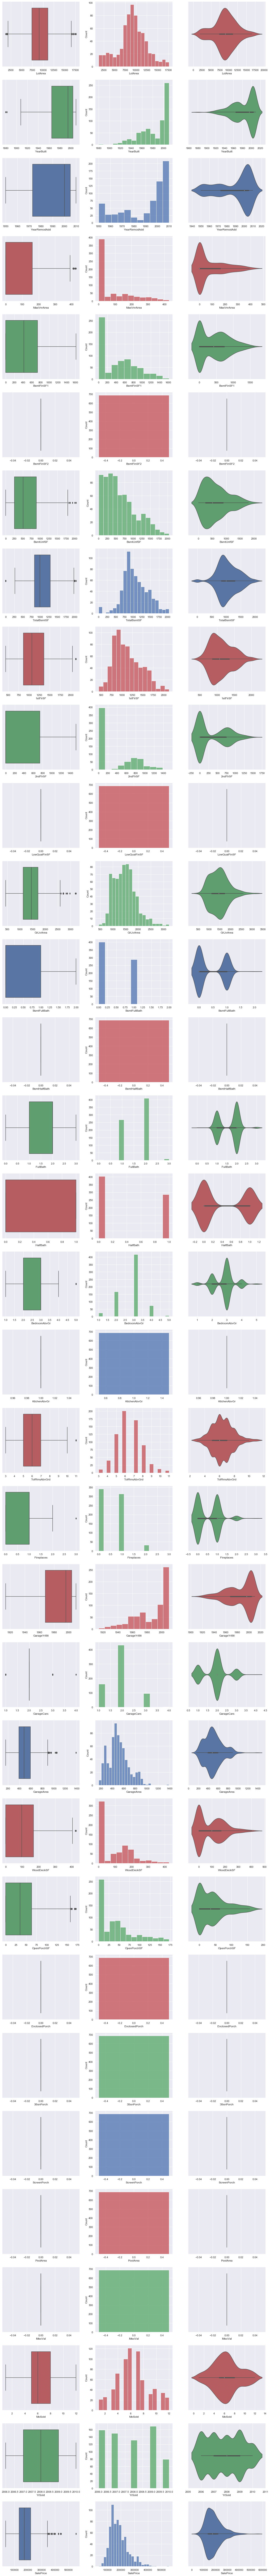

In [12]:
#investigating the skewness of data features (visually)
f, axes = plt.subplots(len(continuous)+1, 3, figsize=(20, 200))
colors = ["r", "g", "b","r","g"]
colors = colors*7

count = 0
for i in continuous+['SalePrice']:
    sb.boxplot(x = train_iqr[i], color = colors[count], ax = axes[count,0])
    sb.histplot(x = train_iqr[i], color = colors[count], ax = axes[count,1])
    sb.violinplot(x = train_iqr[i], color = colors[count], ax = axes[count,2])
    count += 1

[back to top](#top)

## 6. Normalisation  <a class="anchor" id="norm"></a>

Normalisation is where we transform values such that they range between 0 and 1. We will use MinMaxScaler from SciKit Learn to do this.

In [13]:
features = train.copy()
features.drop(['Id', 'SalePrice'], axis=1, inplace=True)

replace = np.array(train[['Id', 'SalePrice']])
# drop Id and SalePrice cause we are not gonna be scaling them. Add back later

In [14]:
# fit scaler on training data
norm = MinMaxScaler().fit(features)
# transform training data
features_norm = norm.transform(features)

In [15]:
# final transformed data as dataframe with Id and SalePrice added in
train = pd.DataFrame(features_norm, columns=features.columns)
train['Id'] = replace.T[0]
train['SalePrice']= replace.T[1]
train.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,SalePrice
0,0.033420,0.946154,0.883333,0.12250,0.125089,0.0,0.064212,0.140098,0.098260,0.413559,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,208500
1,0.038795,0.738462,0.433333,0.00000,0.173281,0.0,0.121575,0.206547,0.193700,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,181500
2,0.046507,0.930769,0.866667,0.10125,0.086109,0.0,0.185788,0.150573,0.113305,0.419370,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,223500
3,0.038561,0.269231,0.333333,0.00000,0.038271,0.0,0.231164,0.123732,0.122943,0.366102,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,140000
4,0.060576,0.923077,0.833333,0.21875,0.116052,0.0,0.209760,0.187398,0.166197,0.509927,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5,250000


[back to top](#top)

## 7. Standardization <a class="anchor" id="stan"></a>

Standardization will transform data into a distribution with a mean of 0 and standard deviation of 1. We will use StandardScaler from SciKit Learn to do this.

In [16]:
features = train.copy()

# transform
for i in continuous:
    # fit on training data column
    scale = StandardScaler().fit(train[[i]])
    # transform training data column
    features[i] = scale.transform(features[[i]])
    
features.drop(['Id', 'SalePrice'], axis=1, inplace=True)

In [17]:
train = pd.DataFrame(features, columns=features.columns)
train['Id'] = replace.T[0]
train['SalePrice']= replace.T[1]
train.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,SalePrice
0,-0.218825,1.029146,0.864397,0.471073,0.548776,-0.293876,-0.947855,-0.499247,-0.830872,1.139894,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,208500
1,-0.106353,0.109538,-0.456189,-0.591131,1.141603,-0.293876,-0.645978,0.433229,0.223013,-0.803943,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,181500
2,0.055020,0.961026,0.815486,0.286813,0.069283,-0.293876,-0.308055,-0.352256,-0.664743,1.167208,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,223500
3,-0.111243,-1.968095,-0.749653,-0.591131,-0.519185,-0.293876,-0.069257,-0.728921,-0.558316,0.916831,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,140000
4,0.349403,0.926967,0.717665,1.305662,0.437621,-0.293876,-0.181898,0.164510,-0.080693,1.592849,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5,250000


[back to top](#top)

## 8. Feature Selection <a class="anchor" id="feature"></a>
Feature selection is choosing data that is relevant or that are most helpful in training the model. This will increase accuracy by preventing the model from learning based on irrelevent features.
<br><br>
Here, we will choose variables that are correlated to SalePrice with an absolute value of more than 0.2.

In [18]:
# variables most closely related to SalePrice
corr = train.corr()['SalePrice']
# print(corr)
feature_select=[]
corrshape=corr.nlargest(corr.shape[0])[1:corr.shape[0]].shape[0]
# print(corrshape)
for i in range(corrshape-1):
    if (abs(corr.nlargest(corrshape)[1:corrshape][i])>0.2):
        feature_select.append(corr.nlargest(corrshape)[1:corrshape].axes[0][i])
        
print('Number of features selected = ', len(feature_select))        
print(corr.nlargest(corrshape)[1:corrshape])

Number of features selected =  68
GrLivArea            0.709783
GarageCars           0.636173
GarageArea           0.607197
TotalBsmtSF          0.603284
1stFlrSF             0.596087
                       ...   
OverallQual_5       -0.383080
GarageType_Detchd   -0.406550
BsmtQual_TA         -0.456964
GarageFinish_Unf    -0.485273
KitchenQual_TA      -0.527689
Name: SalePrice, Length: 246, dtype: float64


In [19]:
train = train[feature_select+['Id', 'SalePrice']]
train.head()

,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,BsmtQual_Ex,TotRmsAbvGrd,KitchenQual_Ex,YearBuilt,...,HeatingQC_TA,MasVnrType_None,Foundation_CBlock,OverallQual_5,GarageType_Detchd,BsmtQual_TA,GarageFinish_Unf,KitchenQual_TA,Id,SalePrice
0,0.339976,0.207038,0.255686,-0.499247,-0.830872,0.772268,0.0,0.910628,0.0,1.029146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,208500
1,-0.522724,0.207038,-0.217635,0.433229,0.223013,0.772268,0.0,-0.346993,0.0,0.109538,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2,181500
2,0.486327,0.207038,0.578405,-0.352256,-0.664743,0.772268,0.0,-0.346993,0.0,0.961026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,223500
3,0.353456,1.791633,0.761280,-0.728921,-0.558316,-1.055033,0.0,0.281817,0.0,-1.968095,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4,140000
4,1.279704,1.791633,1.804738,0.164510,-0.080693,0.772268,0.0,1.539439,0.0,0.926967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,250000


[back to top](#top)